# All Statistics 8.5.3

Create a sample of size 100 from normal distribution, and use DKW inequality to create a 95% confidence band from the sample. Then check wither the normal cdf lies in the confidence band.

Do this 1000 times to see what the confidence actually is of the constructed confidence bands.

Doing this experiment once gave a confidence of 0.971.
Standard error of this confidence approximately equals sqrt(0.971*(1-0.971)/1000) = 0.005.

In [2]:
from tqdm.notebook import tqdm

import math
import numpy as np
from scipy.stats import norm
from numba import vectorize, float64

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(0)

In [51]:
class StepwiseFunction():
    """
    Objects of this class are functions defined as follows:
    given x0<...<xn and y0,...,y(n+1):
    -if xi <= x < x(i+1), then f(x) = y(i+1)
    -if x < x0, then f(x) = y0
    -if xn <= x, then f(x) = y(n+1)
    
    Created to be right continuous as the class is designed for
    cumulative distributive functions of discrete distributions
    """
    def __init__(self, input_cutoffs, output_values):
        """
        Parameters
        ----------
        input_cutoffs
            np array. ordered list of values at which the
            functions' values change / list of discontinuities of
            the function
        output_values
            np array. list of output values of the function
        """
        self.input_cutoffs = input_cutoffs
        self.output_values = output_values
    
    def __call__(self, x):
        """
        writing self_cutoffs as x0<...<xn and
        output_values as y0,...,y(n+1), define function so that:
        -if xi <= x < x(i+1), then f(x) = y(i+1)
        -if x < x0, then f(x) = y0
        -if xn <= x, then f(x) = y(n+1)

        Created to be right continuous as the class is designed for
        cumulative distributive functions of discrete distributions
        """
        for index in range(len(self.input_cutoffs)):
            if x < self.input_cutoffs[index]:
                return self.output_values[index]
            else:
                continue
        
        # if function has not yet returned, then x >= xn
        return self.output_values[-1]
    
    def plot(self, ax, padding = 2, color = 'blue'):
        """
        plot the function represented by self onto the provided axis
        
        Parameters
        ----------
        ax
            the axis object in which the plots should be added
        padding
            how far below x0 and above xn we should plot
        color
            color of new data to be added to the plot
        
        Returns
        -------
        ax
            axis with new data added to it
        """
        xs = self.input_cutoffs
        ys = self.output_values
        
        # plot regions between x0 and xn
        for i in range(0, len(xs)-1):
            x = [xs[i], xs[i+1]]
            y = [ys[i+1], ys[i+1]]
            ax.plot(x, y, color=color)
            
        # plot regions below x0 and above xn
        ax.plot([xs[0] - padding, xs[0]], [ys[0], ys[0]], color = color)
        ax.plot([xs[-1], xs[-1] + [padding]], [ys[-1], ys[-1]], color = color)
        
        # plot points to indicate the value of the function at the cutoffs
        ax.scatter(xs, ys[1:], color=color)
        
        return ax
        

In [52]:
xs = np.arange(5)
ys = np.arange(6)

test = StepwiseFunction(xs, ys)

print(test.input_cutoffs)
print(test.output_values)

[0 1 2 3 4]
[0 1 2 3 4 5]


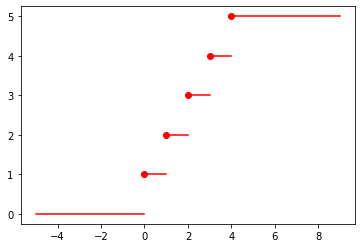

In [54]:
fig, ax = plt.subplots()
ax = test.plot(ax, color = 'red', padding = 5)

In [3]:
def create_empirical_dist_fn(sample):
    """
    takes as input a sample, and outputs the empirical distribution
    function of the sample
    """
    n = len(sample)
    def Fn(x):
        return (sample < x).sum()/n
    return Fn

In [4]:
def create_confidence_band(sample, alpha):
    """
    takes as input a sample, and outputs a 1-alpha confidence band for the
    cdf of generating distribution, using bounds from dwk inequality
    output is Ln and Un which give lower bound and upper bound of
    cdf
    """
    n = len(sample)
    Fn = create_empirical_dist_fn(sample)
    eps_n = (math.log(2/alpha)/2/n)**0.5
    
    @vectorize([float64(float64)])
    def Ln(x):
        Fnx = Fn(x)
        return max(0, Fnx - eps_n)
    
    @vectorize([float64(float64)])
    def Un(x):
        Fnx = Fn(x)
        return min(1, Fnx + eps_n)
    
    return Ln, Un

In [5]:
def test_sample(sample, alpha, plot = False):
    """
    takes as input a sample, and determines if the 1-alpha confidence band
    produced from it contains the true cdf
    
    if optional argument plot is True, produces a line plot to visualise whether
    the cdf is contained in the band or not
    """
    Ln, Un = create_confidence_band(sample, alpha)
    x = np.arange(min(sample)+0.1, max(sample), 0.1)
    Lnx = Ln(x)
    Unx = Un(x)
    norm_x = norm.cdf(x)
    
    if plot:
        plt.plot(x, Lnx)
        plt.plot(x, Unx)
        plt.plot(x, norm_x)
        plt.show()
    return np.logical_and((norm_x >= Lnx).all(), (norm_x <= Unx).all())

In [6]:
sample = np.random.normal(size = 100)

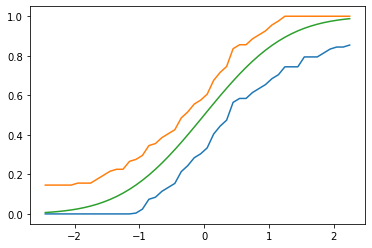

True

In [8]:
test_sample(sample, alpha = 0.05, plot=True)

In [9]:
def create_test_N_samples(N, sample_size = 100, alpha = 0.05):
    """
    create N samples, and determine what proportion of them produce confidence
    bands that contain the true cdf
    """
    within_confidence_band = 0
    for i in tqdm(range(N)):
        sample = np.random.normal(size = sample_size)
        within_confidence_band += test_sample(sample, alpha)
    
    return within_confidence_band / N

In [11]:
ratio = create_test_N_samples(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
ratio

0.971